In [158]:
from dolfin import *
import numpy as np
# import pygad
import pyswarms as ps
import matplotlib.pyplot as plt
import mshr as mr

set_log_level(50)

vertex number: 1167
cell number: 2107


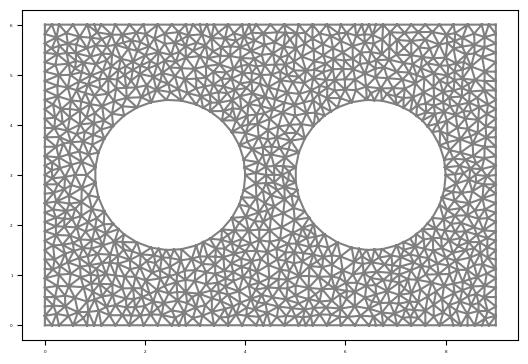

In [159]:
# 创建网格
rectangle = mr.Rectangle(Point(0.0, 0.0), Point(9.0, 6.0))
# rectangle1 = mr.Rectangle(Point(4,0), Point(9,5))
circle1 = mr.Circle(Point(2.5, 3.0), 1.5)
circle2 = mr.Circle(Point(6.5, 3.0), 1.5)
domain = rectangle - circle1 - circle2

# 创建网格
mymesh = mr.generate_mesh(domain, 32)
vertex_num = mymesh.num_vertices()
cell_num = mymesh.num_cells()
plot(mymesh)
print(f"vertex number: {vertex_num}")
print(f"cell number: {cell_num}")

In [160]:
# 初始化
"""初始化"""
# 二维正交各向异性
E1, E2, mu12, G12 = 130000, 7700, 0.33, 4800
# E1, E2, mu12, G12 = 130000, 130000, 0.33, 4800
# 转动角度
Theta = 0
Theta_init = 5
# 载荷
forcing = Constant((500, 0))

# 弹性张量
C2D_Iso = np.array([
    [E1/(1-mu12**2),        mu12*E2/(1-mu12**2),         0  ],
    [mu12*E2/(1-mu12**2),   E2/(1-mu12**2),              0  ],
    [0,                     0,                           G12]
])

# 转轴公式
def T2D_inv(theta):
    theta = theta * np.pi / 180.0
    c = cos(theta)
    s = sin(theta)
    Trans = np.array([
        [c**2,  s**2,   -2*s*c],
        [s**2,  c**2,   2*s*c],
        [s*c,   -s*c,   c**2 - s**2]
    ])
    return Trans

# 准备网格
V = VectorFunctionSpace(mymesh, "CG", 1)
T = FunctionSpace(mymesh, "DG", 0)
u_sol = Function(V)
Theta_sol = Function(T)
u_trial = TrialFunction(V)
v_test = TestFunction(V)

In [161]:
# 定义物理方程
# 物理方程
def epsilon(u):
    engineering_strain = 0.5 * (nabla_grad(u) + nabla_grad(u).T)
    return engineering_strain

# 本构方程
def sigma_tensor(u, Theta_Ev):
    # 计算应变张量
    epsilon_ij = epsilon(u)
    ep = as_vector([epsilon_ij[0,0], epsilon_ij[1,1], epsilon_ij[0,1]])
    # 使用弹性系数计算应力张量
    Q_bar = np.dot(np.dot(T2D_inv(Theta_Ev), C2D_Iso), T2D_inv(Theta_Ev).T)
    sigma_ij = np.dot(Q_bar, ep)

    return as_tensor([[sigma_ij[0], sigma_ij[2]],
                      [sigma_ij[2], sigma_ij[1]]])

# 弹性能密度
def psi(u, Theta):
    return 0.5 * inner(sigma_tensor(u, Theta), epsilon(u))

In [162]:
# 定义边界
# 狄利克雷边界
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < DOLFIN_EPS
bc = DirichletBC(V, Constant((0.0, 0.0)), clamped_boundary)

# 自然边界
class RightEnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 9) < DOLFIN_EPS 
right_end_boundary = RightEnd()

boundary_mark = MeshFunction("size_t", mymesh, mymesh.topology().dim()-1)
boundary_mark.set_all(0)
right_end_boundary.mark(boundary_mark, 1)

In [163]:
# 有限元求解
def FEA(lhs, rhs, bc:DirichletBC) -> Function:
    u = Function(V) 
    problem = LinearVariationalProblem(lhs, rhs, u, bc)
    solver = LinearVariationalSolver(problem)
    solver.solve()
    return u

f_7620


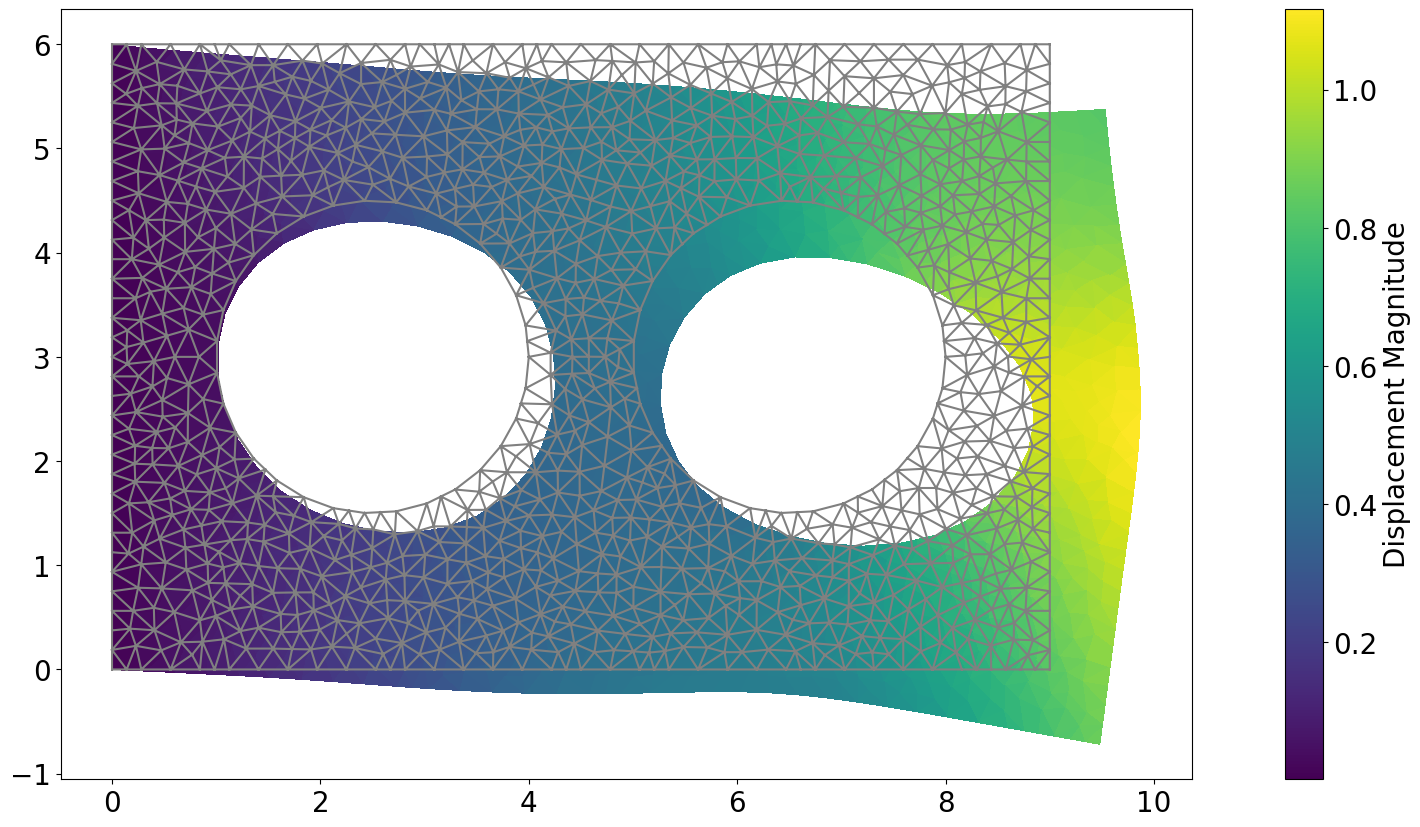

In [171]:
u_results = {}
for angle in [45]:
    u_sol = Function(V)
    theta = angle * np.ones(T.dim())
    theta_init = Function(T)
    theta_init.vector()[:] = theta
    # 有限元计算
    lhs = inner(sigma_tensor(u_trial, theta_init), nabla_grad(v_test)) * dx
    rhs = dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mymesh, subdomain_id=1)
    u_sol = FEA(lhs, rhs, bc=[bc])
    u_results[angle] = u_sol
print(u_results[45])
plt.rcParams.update({'font.size': 20})  # 增加字体大小
plt.figure(figsize=(24,10))
c = plot(u_results[45], mode="displacement", mesh=mymesh, wireframe=True)
plot(mymesh)
plt.colorbar(c, label='Displacement Magnitude')  # 修改颜色条标签为英文
plt.show()

In [165]:
# 计算并存储不同初始角度下的变形结果
results = {}
for angle in np.arange(-90, 91, 15):
    theta = angle * np.ones(T.dim())
    theta_init = Function(T)
    theta_init.vector()[:] = theta
    # 有限元计算
    lhs = inner(sigma_tensor(u_trial, theta_init), nabla_grad(v_test)) * dx
    rhs = dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mymesh, subdomain_id=1)
    u_sol = FEA(lhs, rhs, bc=[bc])
    results[angle] = u_sol
    
print(f"Results contain {len(results)} sets of data.")
# plot(results[60], title=f"Deformation U", mode="displacement", mesh=mymesh, wireframe=True, cmap='viridis')

Results contain 13 sets of data.


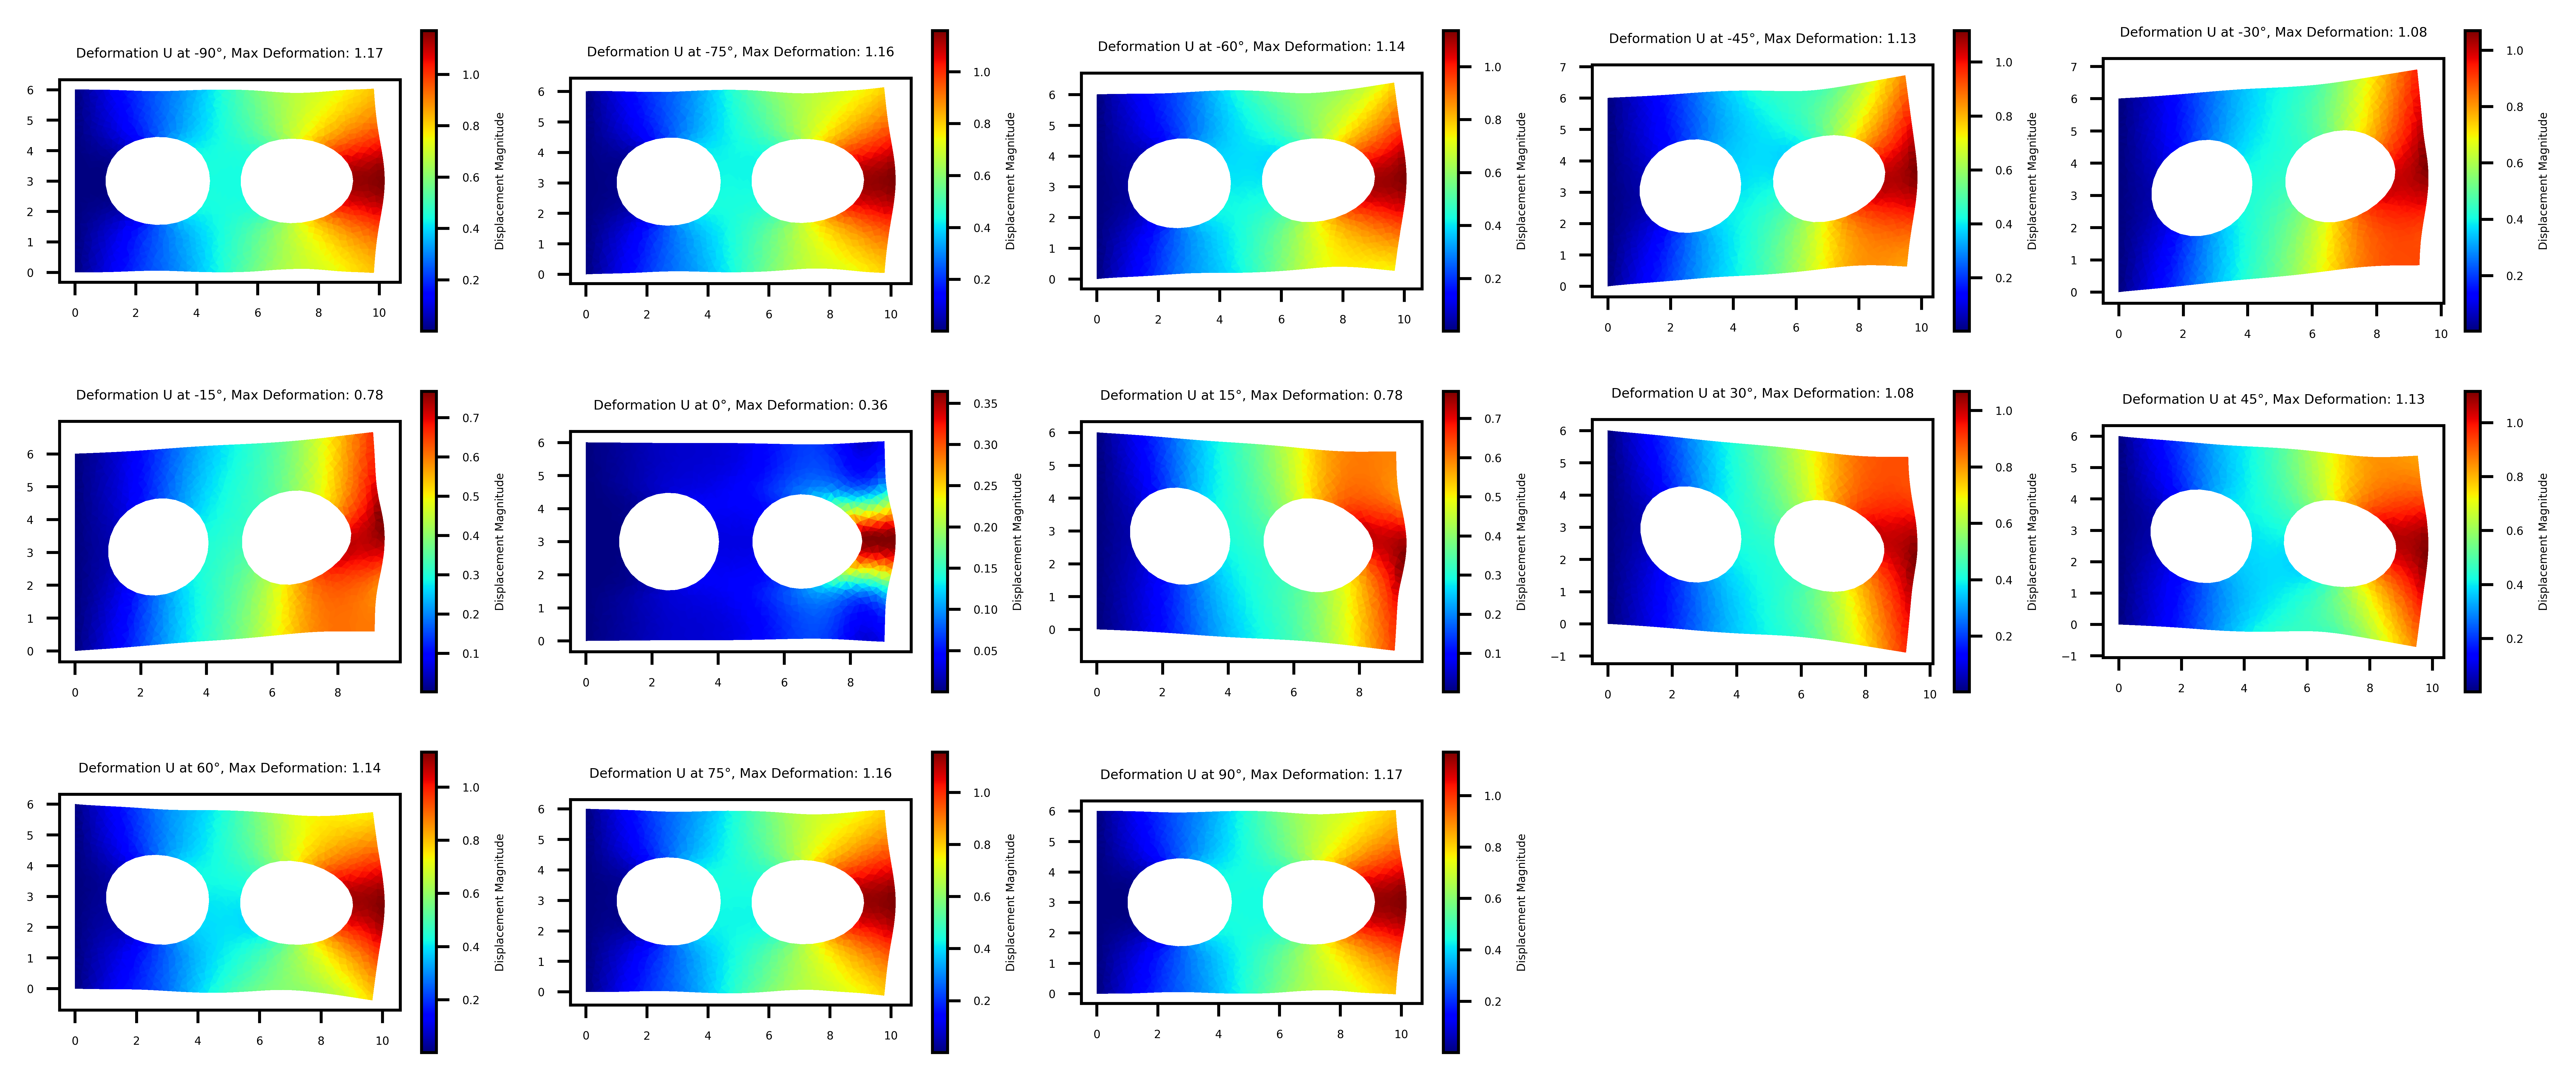

In [166]:
# import matplotlib.pyplot as plt
# plt.figure(dpi=300)
# plot(results[15], title="deformation U", mode="displacement", mesh=mymesh, wireframe=True)
# plt.show()

import matplotlib.pyplot as plt
# 设置全局字体大小
plt.rcParams.update({'font.size': 3})

# 绘制结果
plt.figure(figsize=(12, 5), dpi=1000)
for i, angle in enumerate(range(-90, 91, 15)):
    plt.subplot(3,5,i+1)
    c = plot(results[angle], title=f"Deformation U at {angle}°", mode="displacement", mesh=mymesh, wireframe=True, cmap='jet')
    plt.colorbar(c, label='Displacement Magnitude')
    # 计算最大变形值和位置
    # 将结果从1列转换为2列
    result_reshaped = np.reshape(results[angle].vector().get_local(), (-1, 2))
    max_deformation = np.max(np.linalg.norm(result_reshaped, axis=1))
    max_deformation_point = np.argmax(np.linalg.norm(result_reshaped, axis=1))
    plt.title(f"Deformation U at {angle}°, Max Deformation: {max_deformation:.2f}")

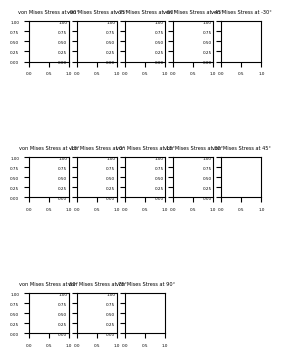

In [167]:
# 绘制每个角度下的von Mises应力图
plt.figure(figsize=(3, 5), dpi=100)
for i, angle in enumerate(range(-90, 91, 15)):
    plt.subplot(3,5,i+1)
    # 计算应力场
    stress = sigma_tensor(results[angle], theta_init)
    # 计算von Mises应力
    von_mises_stress = sqrt(1/2 * ((stress[0,0] - stress[1,1])**2 + 6*(stress[0,1]**2)))
    # 创建一个标量函数空间来存储von Mises应力
    V_scalar = FunctionSpace(mymesh, 'CG', 1)
    von_mises_stress_func = Function(V_scalar)
    von_mises_stress_func.assign(project(von_mises_stress, V_scalar))
    # 绘制von Mises应力场
    c = plot(von_mises_stress_func, title=f"von Mises Stress at {angle}°", mode="stress", mesh=mymesh, wireframe=True, cmap='viridis')
plt.show()



Max Principal Stress Values: [492.44178721 514.0308667  496.41124244 ... 845.58416838 818.50271482
 957.45908796]
Max Principal Direction Values: [ 0.9999777  -0.006679    0.99999802 ...  0.00515943  0.99871482
 -0.05068237]


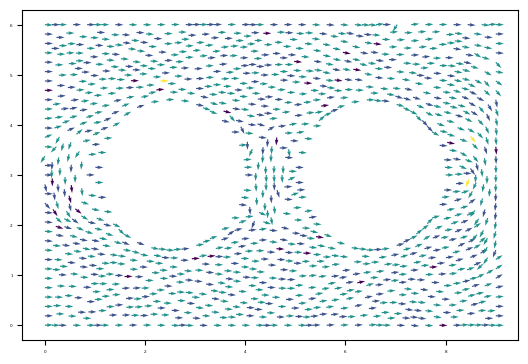

In [168]:
# 计算最大主应力场
stress = sigma_tensor(u_sol, theta_init)
# 创建一个张量函数空间来存储应力场
V_ten = TensorFunctionSpace(mymesh, 'CG', 1)
stress_func = Function(V_ten)

stress_func.assign(project(stress, V_ten))

# 定义函数空间
V_max_principal = FunctionSpace(mymesh, 'CG', 1)
V_vec = VectorFunctionSpace(mymesh, 'CG', 1)

# 定义最大主应力函数和方向函数
max_principal_stress = Function(V_max_principal)
max_principal_direction = Function(V_vec)

# 提取应力值
stress_values = stress_func.vector().get_local().reshape((-1, 2, 2))

# 获取本地向量大小
local_size_stress = max_principal_stress.vector().local_size()
local_size_direction = max_principal_direction.vector().local_size()

# 初始化最大主应力和方向数组
max_principal_stress_values = np.zeros(local_size_stress)
max_principal_direction_values = np.zeros((local_size_direction // 2, 2))  # 确保方向是2维

# 计算最大主应力和方向
for i, stress_tensor in enumerate(stress_values):
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    max_index = np.argmax(eigenvalues)
    max_principal_stress_values[i] = eigenvalues[max_index]
    max_principal_direction_values[i] = eigenvectors[:, max_index]

# 将最大主应力值和方向赋值给相应的函数
max_principal_stress.vector().set_local(max_principal_stress_values)
max_principal_direction.vector().set_local(max_principal_direction_values.flatten())

# 打印最大主应力值和方向
print("Max Principal Stress Values:", max_principal_stress.vector().get_local())
print("Max Principal Direction Values:", max_principal_direction.vector().get_local())
plot(max_principal_direction)

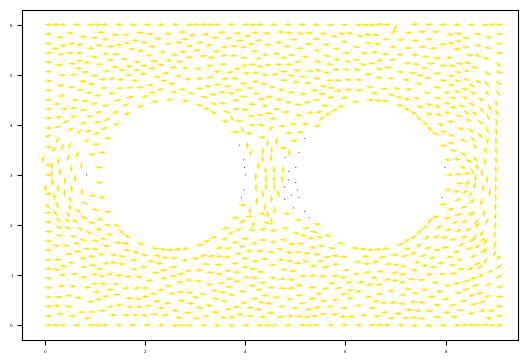

In [169]:
# 计算拉应力场和压应力场
stress = sigma_tensor(u_sol, theta_init)

# 创建一个张量函数空间来存储应力场
V_ten = TensorFunctionSpace(mymesh, 'CG', 1)
stress_func = Function(V_ten)

stress_func.assign(project(stress, V_ten))

# 定义函数空间
V_scalar = FunctionSpace(mymesh, 'CG', 1)
V_vec = VectorFunctionSpace(mymesh, 'CG', 1)

# 定义拉应力和压应力函数及其方向函数
tensile_stress = Function(V_scalar)
compressive_stress = Function(V_scalar)
tensile_direction = Function(V_vec)
compressive_direction = Function(V_vec)

# 提取应力值
stress_values = stress_func.vector().get_local().reshape((-1, 2, 2))

# 获取本地向量大小
local_size_stress = tensile_stress.vector().local_size()
local_size_direction = tensile_direction.vector().local_size()

# 初始化拉应力和压应力及其方向数组
tensile_stress_values = np.zeros(local_size_stress)
compressive_stress_values = np.zeros(local_size_stress)
tensile_direction_values = np.zeros((local_size_direction // 2, 2))  # 确保方向是2维
compressive_direction_values = np.zeros((local_size_direction // 2, 2))  # 确保方向是2维

# 计算拉应力和压应力及其方向
for i, stress_tensor in enumerate(stress_values):
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    
    # 分别获取拉应力和压应力及其方向
    tensile_eigenvalues = eigenvalues[eigenvalues > 0]
    compressive_eigenvalues = eigenvalues[eigenvalues < 0]
    
    if len(tensile_eigenvalues) > 0:
        max_tensile_index = np.argmax(tensile_eigenvalues)
        tensile_stress_values[i] = tensile_eigenvalues[max_tensile_index]
        tensile_direction_values[i] = eigenvectors[:, eigenvalues == tensile_eigenvalues[max_tensile_index]].flatten()
    else:
        tensile_stress_values[i] = 0
        tensile_direction_values[i] = [0, 0]
    
    if len(compressive_eigenvalues) > 0:
        max_compressive_index = np.argmin(compressive_eigenvalues)
        compressive_stress_values[i] = compressive_eigenvalues[max_compressive_index]
        compressive_direction_values[i] = eigenvectors[:, eigenvalues == compressive_eigenvalues[max_compressive_index]].flatten()
    else:
        compressive_stress_values[i] = 0
        compressive_direction_values[i] = [0, 0]

# 将拉应力和压应力值及其方向赋值给相应的函数
tensile_stress.vector().set_local(tensile_stress_values)
compressive_stress.vector().set_local(compressive_stress_values)
tensile_direction.vector().set_local(tensile_direction_values.flatten())
compressive_direction.vector().set_local(compressive_direction_values.flatten())

# 绘制拉应力方向场
plot(tensile_direction)
# 绘制压应力方向场
# plot(compressive_direction)

In [170]:
# 可视化
def plot_theta_vector(theta:Function, mesh, scale=30, width=0.001, title="Vector field"):
    theta_rad = np.deg2rad(Theta_sol.vector()[:])  # 将角度转换为弧度
    x_values = np.cos(theta_rad)
    y_values = np.sin(theta_rad)
    # 将二维向量表示合并为一个二维数组
    vector_values = np.vstack((x_values, y_values)).T  # 转置使每行是一个向量
    # 获取网格的中心点
    cell_midpoints = [cell.midpoint() for cell in cells(mesh)]
    # 提取中心点的坐标
    x_coords = np.array([p.x() for p in cell_midpoints])
    y_coords = np.array([p.y() for p in cell_midpoints])
    u = vector_values[:, 0]
    v = vector_values[:, 1]
    # 可视化向量场
    plt.figure()
    # plot(mesh)
    # plt.quiver(x_coords, y_coords, u, v)
    # 绘制正方向的箭头
    plt.quiver(x_coords, y_coords, u, v, angles='xy', scale_units='xy', scale=scale, width=width, color='b')
    # 绘制反方向的箭头
    plt.quiver(x_coords, y_coords, -u, -v, angles='xy', scale_units='xy', scale=scale, width=width, color='b')

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()